# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import napari
from macrohet import dataio, tile
import btrack
import os

In [2]:
btrack.__version__

'0.6.1.dev31'

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [3]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [4]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [5]:
row = 3
column = 5

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [6]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
#                              set_channel=1,
                             set_time = 0,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()

In [7]:
%%time
images = images.compute().compute()

CPU times: user 2min 49s, sys: 9.84 s, total: 2min 59s
Wall time: 13.6 s


# Load tracks

### Downscaled

In [8]:
with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/relocalisation/relocalised_{row, column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks    
        segmentation = reader.segmentation
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)

[INFO][2023/05/02 03:49:03 PM] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(3, 5).h5...
[INFO][2023/05/02 03:49:04 PM] Loading tracks/obj_type_1
[INFO][2023/05/02 03:49:04 PM] Loading LBEP/obj_type_1
[INFO][2023/05/02 03:49:04 PM] Loading objects/obj_type_1 (28787, 5) (28787 filtered: None)
[INFO][2023/05/02 03:49:15 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/05/02 03:49:15 PM] Closing HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(3, 5).h5


### Recolour segmentation

In [9]:
col_segmentation = btrack.utils.update_segmentation(segmentation, tracks, scale = (5.04, 5.04) )

# Launch napari image viewer

In [221]:
viewer = napari.Viewer()
viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green",  "magenta"],
                 contrast_limits=[[0,6000], [0,1000]], 
                 visible = True
                 )
segmentation_layer = viewer.add_labels(segmentation[0],
                              
#                   scale=(5.04, 5.04,))
                  #color='yellow'
                 )
tracker_layer = viewer.add_tracks(napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
                    scale = (1,5.04,5.04)
                )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [17]:
### think i need to add pre- scaled tracks to get key binding to work
from macrohet import visualise

In [18]:
pre_scaled_napari_tracks = visualise.scale_napari_tracks(napari_tracks)

In [19]:
tracker_layer = viewer.add_tracks(pre_scaled_napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
#                     scale = (1,5.04,5.04)
                )

# BUG

In [224]:
output_dir = '/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/bg_rm'
@viewer.bind_key('p', overwrite=True)
def Mtb_pos(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment (mean intensity is now for both channels hence last index)
    px_int =  positive_track['mean_intensity'][cell_index][1]
    area = positive_track['area'][cell_index]
    # print to check
    print(cell_ID, px_int)
    ### write to output file
    with open(os.path.join(output_dir, "Mtb_positive.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "Mtb_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int, area}\n")
@viewer.bind_key('n', overwrite=True)
def Mtb_neg(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        negative_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = negative_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  negative_track['mean_intensity'][cell_index][1]
    area = negative_track['area'][cell_index]
    # print to check
    print(cell_ID, px_int)
    ### write to output file
    with open(os.path.join(output_dir, "Mtb_negative.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "Mtb_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int, area}\n")

# comparing sc fluroescent signals

In [50]:
cell_361 = [cell for cell in tracks if cell.ID ==361][0]
cell_112 = [cell for cell in tracks if cell.ID ==112][0]

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

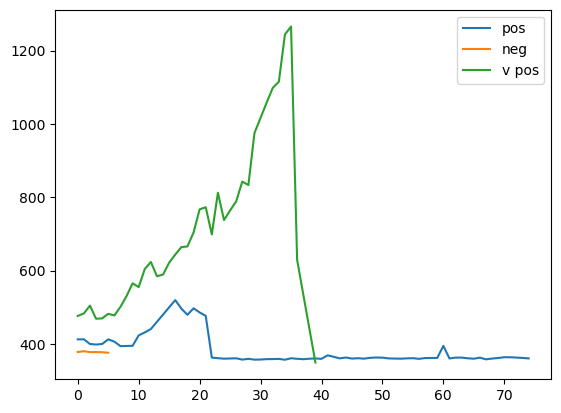

In [51]:
sns.lineplot(data = cell_361['mean_intensity'][:,1], label = 'pos')
sns.lineplot(data = cell_319['mean_intensity'][:,1], label = 'neg')
sns.lineplot(data = cell_112['mean_intensity'][:,1], label = 'v pos')

plt.legend()

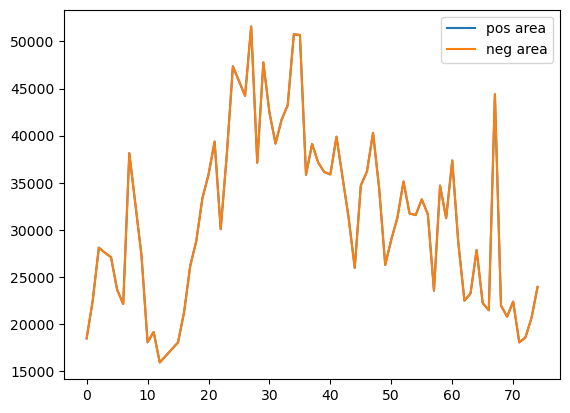

In [49]:
sns.lineplot(data = cell_361['area'], label = 'pos area')
sns.lineplot(data = cell_361['area'], label = 'neg area')

plt.legend()

# Assessing manual thresholding

In [86]:
import pandas as pd

# Load positive values CSV file into a pandas dataframe
df_pos = pd.read_csv('/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/Mtb_positive.csv', header=None, names=['Mean Pixel Value'])
# Add a new column 'label' with value 'positive'
df_pos['label'] = 'positive'

# Load negative values CSV file into a pandas dataframe
df_neg = pd.read_csv('/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/Mtb_negative.csv', header=None, names=['Mean Pixel Value'])
# Add a new column 'label' with value 'negative'
df_neg['label'] = 'negative'

# Concatenate the positive and negative dataframes vertically
df = pd.concat([df_pos, df_neg], axis=0)

# Reset the index of the merged dataframe
df.reset_index(drop=True, inplace=True)


In [87]:
df

,Mean Pixel Value,label
0,376.936859,positive
1,412.553833,positive
2,378.703796,positive
3,384.623138,positive
4,366.230682,positive
...,...,...
419,370.857178,negative
420,358.679199,negative
421,374.481873,negative
422,377.519257,negative


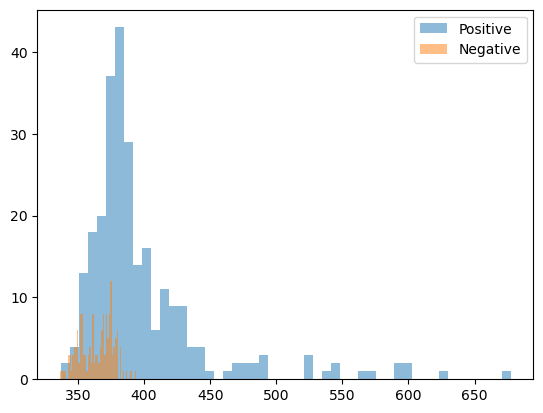

In [89]:
import matplotlib.pyplot as plt

# Separate the positive and negative values into separate dataframes
df_pos = df[df['label'] == 'positive']
df_neg = df[df['label'] == 'negative']

# Plot the histograms
plt.hist(df_pos['Mean Pixel Value'], bins=50, alpha=0.5, label='Positive')
plt.hist(df_neg['Mean Pixel Value'], bins=50, alpha=0.5, label='Negative')
plt.legend(loc='upper right')
plt.show()

### Assessing threshold of total Mtb

In [118]:
import pandas as pd

# Load positive values CSV file into a pandas dataframe
df_pos = pd.read_csv('/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/Mtb_positive_details.csv', header=None, names=['Cell ID', 'Time', 'Mean Pixel Value', 'Area'])
# Add a new column 'label' with value 'positive'
df_pos['label'] = 'positive'

# Load negative values CSV file into a pandas dataframe
df_neg = pd.read_csv('/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/Mtb_negative_details.csv', header=None, names=['Cell ID', 'Time', 'Mean Pixel Value', 'Area'])
# Add a new column 'label' with value 'negative'
df_neg['label'] = 'negative'

# Concatenate the positive and negative dataframes vertically
df = pd.concat([df_pos, df_neg], axis=0)

# Reset the index of the merged dataframe
df.reset_index(drop=True, inplace=True)
# df = df.replace(to_replace=['(', ')'], value='', regex=True)
df['Cell ID'] = df['Cell ID'].str.replace(r'[()]', '')
df['Area'] = df['Area'].str.replace(r'[()]', '')
df = df.drop_duplicates(subset=['Cell ID'])
# Convert the columns to the appropriate numeric type
df['Mean Pixel Value'] = df['Mean Pixel Value'].astype(float)
df['Area'] = df['Area'].astype(float)

# Add a new column for the summed pixel intensity
df['Summed intensity'] = df['Mean Pixel Value'] * df['Area']


/tmp/ipykernel_1612980/3303777704.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Cell ID'] = df['Cell ID'].str.replace(r'[()]', '')
/tmp/ipykernel_1612980/3303777704.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Area'] = df['Area'].str.replace(r'[()]', '')


In [119]:
df

,Cell ID,Time,Mean Pixel Value,Area,label,Summed intensity
0,310,0.0,376.936859,28036.0,positive,1.056780e+07
1,361,0.0,412.553833,18479.0,positive,7.623582e+06
2,346,0.0,378.703796,76096.0,positive,2.881784e+07
3,272,0.0,384.623138,57299.0,positive,2.203852e+07
4,273,0.0,366.230682,14726.0,positive,5.393113e+06
...,...,...,...,...,...,...
419,209,0.0,370.857180,25633.0,negative,9.506182e+06
420,192,0.0,358.679199,77104.0,negative,2.765560e+07
421,168,0.0,374.481873,21249.0,negative,7.957365e+06
422,236,0.0,377.519257,82198.0,negative,3.103133e+07


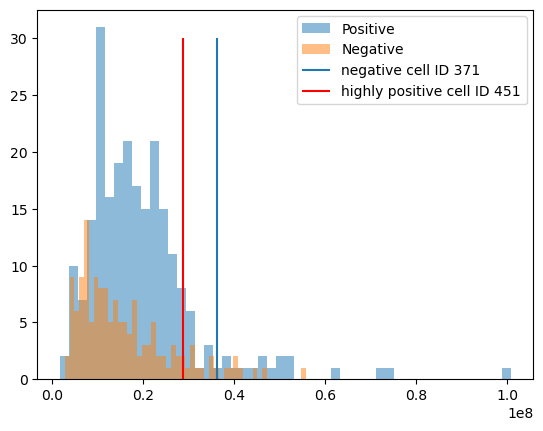

In [130]:
import matplotlib.pyplot as plt

# Separate the positive and negative values into separate dataframes
df_pos = df[df['label'] == 'positive']
df_neg = df[df['label'] == 'negative']
# Plot the histograms
plt.hist(df_pos['Summed intensity'], bins=50, alpha=0.5, label='Positive')
plt.hist(df_neg['Summed intensity'], bins=50, alpha=0.5, label='Negative')
plt.vlines(36284242, ymin = 0, ymax = 30, label = 'negative cell ID 371')
plt.vlines(28788085.73953247, ymin = 0, ymax = 30, label = 'highly positive cell ID 451', color = 'red')
plt.legend(loc='upper right')
plt.show()

# WTF

These should not be overlapping at all!

In [122]:
print('Area, mean int', [track for track in tracks if track.ID == 451][0]['area'][0], [track for track in tracks if track.ID == 451][0]['mean_intensity'][0])
print('sum int', [track for track in tracks if track.ID == 451][0]['area'][0]*[track for track in tracks if track.ID == 451][0]['mean_intensity'][0][-1])

Area, mean int 80081.0 [1890.44628906  359.48709106]
sum int 28788085.73953247


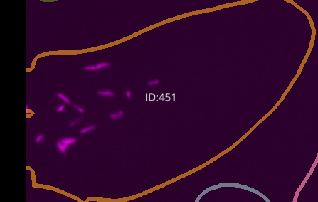

In [123]:
print('Area, mean int', [track for track in tracks if track.ID == 371][0]['area'][0], [track for track in tracks if track.ID == 371][0]['mean_intensity'][0])
print('sum int', [track for track in tracks if track.ID == 371][0]['area'][0]*[track for track in tracks if track.ID == 371][0]['mean_intensity'][0][-1])

Area, mean int 102737.0 [1222.06115723  353.17599487]
sum int 36284242.18527222


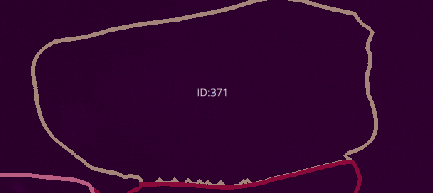

# Isolating a single cell image

In [133]:
rfp_t0 = images[0,1,...]

In [136]:
seg_t0 = segmentation[0]

In [137]:
### segment for 451 has pixel value 125
segment_451 = seg_t0 == 125

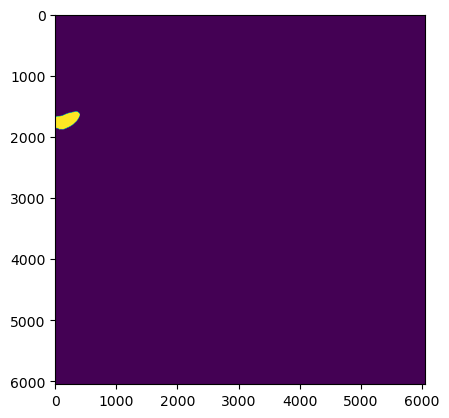

In [138]:
plt.imshow(segment_451)

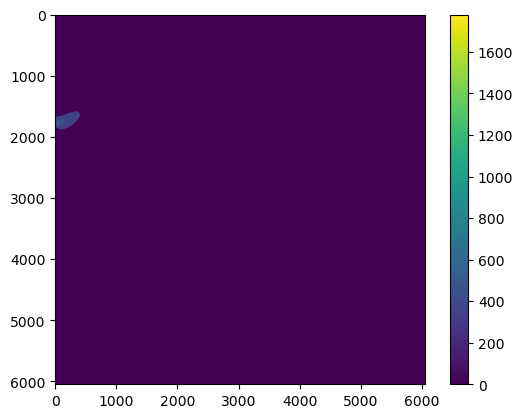

In [149]:
plt.imshow(rfp_t0*segment_451)
plt.colorbar()

In [142]:
import numpy as np

In [143]:
np.sum(rfp_t0*segment_451)

28788086

In [144]:
print('sum int', [track for track in tracks if track.ID == 451][0]['area'][0]*[track for track in tracks if track.ID == 451][0]['mean_intensity'][0][-1])

sum int 28788085.73953247


# Now for negative cell 371

In [145]:
### segment for 371 has pixel value 205
segment_371 = seg_t0 == 205

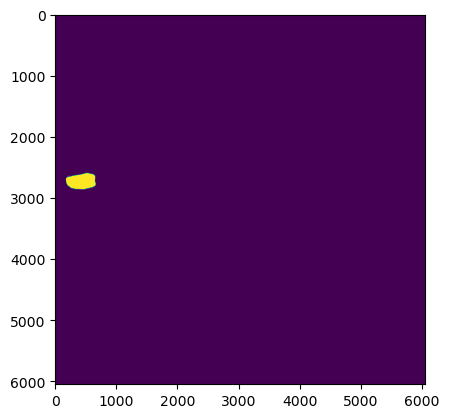

In [146]:
plt.imshow(segment_371)

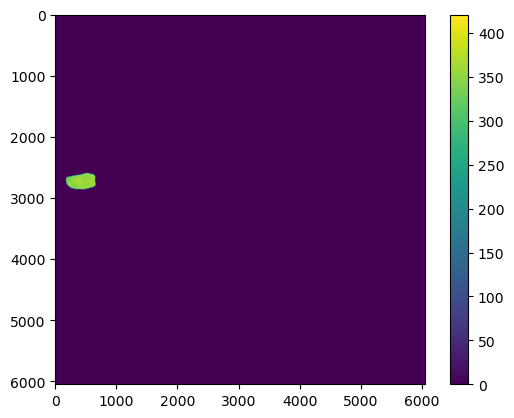

In [148]:
plt.imshow(rfp_t0*segment_371)
plt.colorbar()

In [150]:
np.sum(rfp_t0*segment_371)

36284243

In [151]:
print('sum int', [track for track in tracks if track.ID == 371][0]['area'][0]*[track for track in tracks if track.ID == 371][0]['mean_intensity'][0][-1])

sum int 36284242.18527222


# The localisation step works correctly, 

It correctly extracts the pixel values from the ROI

# Is it the fact that my images are being loaded as 64 bit? - no

In [157]:
rfp_t0_16bit = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
                             set_channel=2,
                             set_time = 0,
#                             input_transforms = [input_transforms]
                            ).compute().compute().astype(np.uint16)[0,0,...]

In [162]:
rfp_t0_16bit.dtype

dtype('uint16')

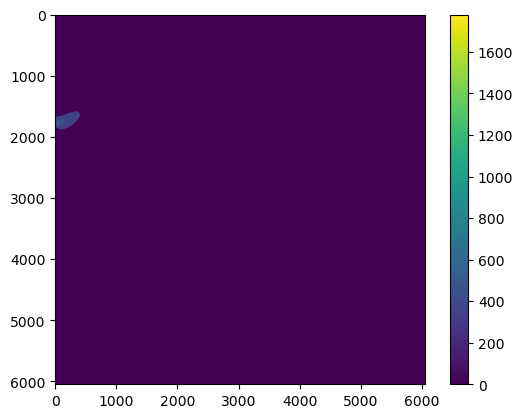

In [158]:
plt.imshow(rfp_t0_16bit*segment_451)
plt.colorbar()

In [160]:
np.sum(rfp_t0_16bit*segment_451)

28788086

In [161]:
print('sum int', [track for track in tracks if track.ID == 451][0]['area'][0]*[track for track in tracks if track.ID == 451][0]['mean_intensity'][0][-1])

sum int 28788085.73953247


# Now for negative cell 371

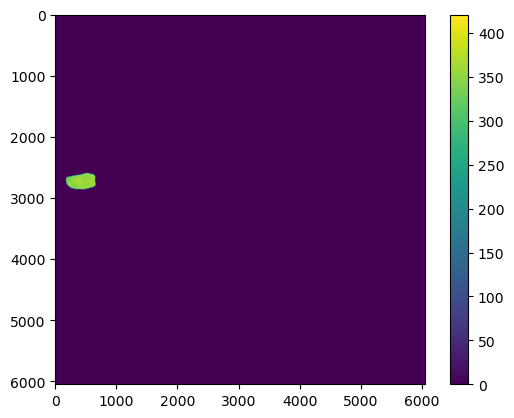

In [163]:
plt.imshow(rfp_t0_16bit*segment_371)
plt.colorbar()

In [164]:
np.sum(rfp_t0_16bit*segment_371)

36284243

In [165]:
print('sum int', [track for track in tracks if track.ID == 371][0]['area'][0]*[track for track in tracks if track.ID == 371][0]['mean_intensity'][0][-1])

sum int 36284242.18527222


# What if I subtract a background

# octolite

In [183]:
from octopuslite import utils

In [204]:
bg = utils.estimate_background(rfp_t0_16bit)

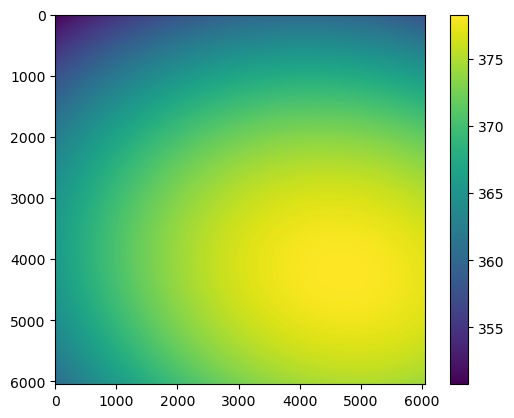

In [206]:
plt.imshow(bg)
plt.colorbar()

In [181]:
corrected = utils.remove_background(rfp_t0_16bit)

In [182]:
viewer.add_image(corrected)

<Image layer 'corrected' at 0x7f7df67d9910>

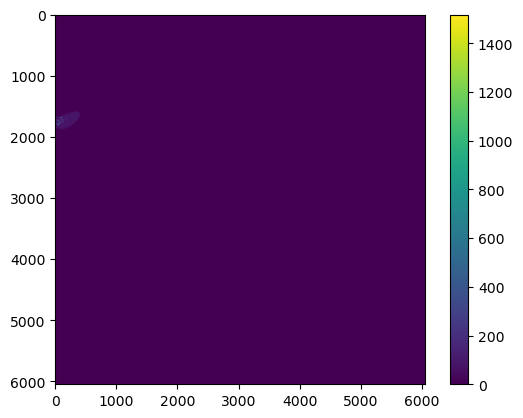

In [184]:
plt.imshow(corrected*segment_451)
plt.colorbar()

In [193]:
np.sum(corrected*segment_451)

7752402.0

In [194]:
np.sum(corrected*segment_451)/np.sum(segment_451)

96.8070079044967

# Now for negative cell 371

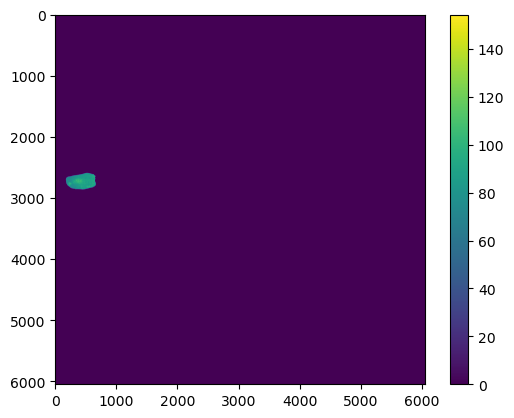

In [187]:
plt.imshow(corrected*segment_371)
plt.colorbar()

In [195]:
np.sum(corrected*segment_371)

8861011.0

In [196]:
np.sum(corrected*segment_371)/np.sum(segment_371)

86.24946221906421

# % difference between positive and negative?

In [200]:
(np.sum(corrected*segment_451)/np.sum(segment_451) - np.sum(corrected*segment_371)/np.sum(segment_371))/(np.sum(corrected*segment_451)/np.sum(segment_451))*100


10.905765929516026

# Conclusion:

The uneven background illumination means that Mtb positive cells in darker regions of the image may even result in lower mean and summed pixel value measurements. In order to circumvent this, a background removal must be conducted on images before the localisation step.

In [207]:
input_transforms = utils.remove_background
test_image = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
                             set_channel=2,
                             set_time = 0,
                            input_transforms = [input_transforms]
                            ).compute().compute().astype(np.uint16)[0,0,...]

In [209]:
viewer.add_image(test_image)

<Image layer 'test_image' at 0x7f7de1981a60>

In [210]:
images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, 
                                 column, 
                                 set_plane = 'sum_proj',
                                 set_time = 0,
                                 input_transforms = [input_transforms]
                                 ).astype(np.uint16)

In [213]:
test_image_2 = images.compute().compute()

In [215]:
test_image_2.shape

(1, 2, 6048, 6048)

In [214]:
viewer.add_image(test_image_2)

<Image layer 'test_image_2' at 0x7f7df7d0f5e0>

# Reloading tracks

In [217]:
with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/relocalisation/relocalised_bg_rm_{row, column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks_bgrm = reader.tracks    
        segmentation = reader.segmentation
napari_tracks_bgrm, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)

[INFO][2023/05/03 10:07:49 am] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_bg_rm_(3, 5).h5...
03-May-23 10:07:49 - btrack.io.hdf - INFO     - Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_bg_rm_(3, 5).h5...
[INFO][2023/05/03 10:07:49 am] Loading tracks/obj_type_1
03-May-23 10:07:49 - btrack.io.hdf - INFO     - Loading tracks/obj_type_1
[INFO][2023/05/03 10:07:49 am] Loading LBEP/obj_type_1
03-May-23 10:07:49 - btrack.io.hdf - INFO     - Loading LBEP/obj_type_1
[INFO][2023/05/03 10:07:50 am] Loading objects/obj_type_1 (28764, 5) (28764 filtered: None)
03-May-23 10:07:50 - btrack.io.hdf - INFO     - Loading objects/obj_type_1 (28764, 5) (28764 filtered: None)
[INFO][2023/05/03 10:08:17 am] Loading segmentation (75, 6048, 6048)
03-May-23 10:08:17 - btrack.io.hdf - INFO     - Loading segmentation (75, 6048, 6048)
[INFO][2023/05/03 10:08:17 am] Closing HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_bg_rm_(3, 5).h5
03-May-23

In [219]:
tracks_bgrm[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,orientation,minor_axis_length,mean_intensity,area,major_axis_length
0,317,0,1067.368652,55.120907,0.000000,317,317,5,0,False,0.543640,297.442078,"(2,) array",79792.0,367.548309
1,317,1,1076.627319,53.511284,0.000000,317,317,5,0,False,0.830746,233.694473,"(2,) array",59611.0,343.924652
2,317,2,1086.090088,46.542519,0.000000,317,317,5,0,False,1.330036,241.751312,"(2,) array",60298.0,321.399139
3,317,3,1067.435425,41.517868,0.000000,317,317,5,0,False,1.387981,224.850403,"(2,) array",59265.0,339.685303
4,317,4,1049.771729,38.330784,0.000000,317,317,5,0,False,1.566783,203.218185,"(2,) array",63411.0,411.977295
5,317,5,1050.415771,41.688465,0.000000,317,317,5,0,False,-1.518311,222.127838,"(2,) array",89396.0,543.717041
6,317,6,1034.244141,41.081558,0.000000,317,317,5,0,False,-1.358899,200.842819,"(2,) array",67568.0,449.364075
7,317,7,1025.088135,37.680584,-3.657916,317,317,5,0,True,NaN,NaN,"(2,) array",NaN,NaN
8,317,8,1032.142212,40.969135,0.000000,317,317,5,0,False,-1.217776,211.361130,"(2,) array",71756.0,464.707703
9,317,9,1060.545654,41.469288,0.000000,317,317,5,0,False,-1.538676,207.644241,"(2,) array",94893.0,647.624390


### Pre bg rm

In [122]:
print('Area, mean int', [track for track in tracks if track.ID == 451][0]['area'][0], [track for track in tracks if track.ID == 451][0]['mean_intensity'][0])
print('sum int', [track for track in tracks if track.ID == 451][0]['area'][0]*[track for track in tracks if track.ID == 451][0]['mean_intensity'][0][-1])

Area, mean int 80081.0 [1890.44628906  359.48709106]
sum int 28788085.73953247


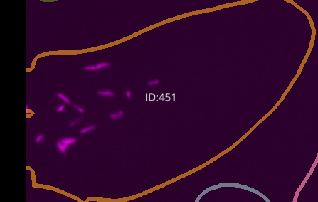

In [123]:
print('Area, mean int', [track for track in tracks if track.ID == 371][0]['area'][0], [track for track in tracks if track.ID == 371][0]['mean_intensity'][0])
print('sum int', [track for track in tracks if track.ID == 371][0]['area'][0]*[track for track in tracks if track.ID == 371][0]['mean_intensity'][0][-1])

Area, mean int 102737.0 [1222.06115723  353.17599487]
sum int 36284242.18527222


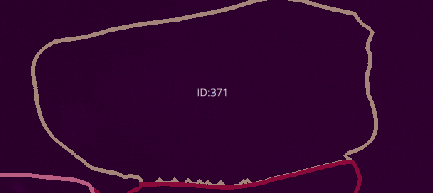

### Post bg rm

In [222]:
print('Area, mean int', [track for track in tracks_bgrm if track.ID == 451][0]['area'][0], [track for track in tracks_bgrm if track.ID == 451][0]['mean_intensity'][0])
print('sum int', [track for track in tracks_bgrm if track.ID == 451][0]['area'][0]*[track for track in tracks_bgrm if track.ID == 451][0]['mean_intensity'][0][-1])

Area, mean int 80081.0 [1922.62353516  116.66760254]
sum int 9342858.278930664


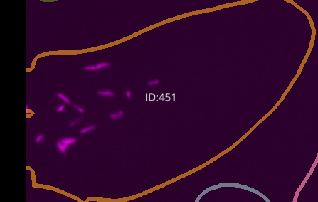

In [223]:
print('Area, mean int', [track for track in tracks_bgrm if track.ID == 371][0]['area'][0], [track for track in tracks_bgrm if track.ID == 371][0]['mean_intensity'][0])
print('sum int', [track for track in tracks_bgrm if track.ID == 371][0]['area'][0]*[track for track in tracks_bgrm if track.ID == 371][0]['mean_intensity'][0][-1])

Area, mean int 102737.0 [1411.3013916    96.26482391]
sum int 9889959.214408875


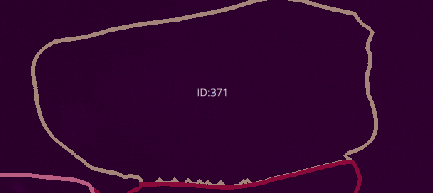

In [229]:
output_dir = '/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/bg_rm'
@viewer.bind_key('p', overwrite=True)
def Mtb_pos(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment (mean intensity is now for both channels hence last index)
    px_int =  positive_track['mean_intensity'][cell_index][1]
    area = positive_track['area'][cell_index]
    # print to check
    print(cell_ID, px_int)
    ### write to output file
    with open(os.path.join(output_dir, "Mtb_positive.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "Mtb_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int, area}\n")
@viewer.bind_key('n', overwrite=True)
def Mtb_neg(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        negative_track = [track for track in tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = negative_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  negative_track['mean_intensity'][cell_index][1]
    area = negative_track['area'][cell_index]
    # print to check
    print(cell_ID, px_int)
    ### write to output file
    with open(os.path.join(output_dir, "Mtb_negative.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "Mtb_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int, area}\n")

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

In [230]:
pre_scaled_napari_tracks = visualise.scale_napari_tracks(napari_tracks_bgrm)

In [ ]:
tracker_layer = viewer.add_tracks(pre_scaled_napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
#                     scale = (1,5.04,5.04)
                )

323 345.0231018066406
308 350.0428466796875
324 353.2033386230469
351 346.1866
358 369.42923
361 412.5538330078125
310 376.9368591308594
353 380.16956
319 378.03397
339 394.500244140625
341 372.3873596191406
346 378.70379638671875
273 366.2306823730469


# Instead of going through the whole image again, just extract the IDs from previous measures

In [232]:
df

,Cell ID,Time,Mean Pixel Value,Area,label,Summed intensity
0,310,0.0,376.936859,28036.0,positive,1.056780e+07
1,361,0.0,412.553833,18479.0,positive,7.623582e+06
2,346,0.0,378.703796,76096.0,positive,2.881784e+07
3,272,0.0,384.623138,57299.0,positive,2.203852e+07
4,273,0.0,366.230682,14726.0,positive,5.393113e+06
...,...,...,...,...,...,...
419,209,0.0,370.857180,25633.0,negative,9.506182e+06
420,192,0.0,358.679199,77104.0,negative,2.765560e+07
421,168,0.0,374.481873,21249.0,negative,7.957365e+06
422,236,0.0,377.519257,82198.0,negative,3.103133e+07


In [249]:
# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=df.columns)

# Iterate over each row in the original DataFrame
for index, row in df.iterrows():
    # Get the cell ID
    cell_ID = int(row['Cell ID'])
    
    # Find the corresponding track in the list of tracks
    track = next((t for t in tracks_bgrm if t.ID == cell_ID), None)
    
    if track is not None:
        # Update the row with the mean pixel value and summed intensity
        row['Mean Pixel Value BG RM'] = track['mean_intensity'][0][1]
        row['Summed intensity BG RM'] = row['Mean Pixel Value BG RM'] * row['Area']
        
        # Append the updated row to the result DataFrame
        result_df = pd.concat([result_df, row.to_frame().T], ignore_index=True)


In [250]:
result_df

,Cell ID,Time,Mean Pixel Value,Area,label,Summed intensity,Mean Pixel Value BG RM,Summed intensity BG RM
0,310,0.0,376.936859,28036.0,positive,10567801.782593,115.802643,3246642.894165
1,361,0.0,412.553833,18479.0,positive,7623582.280151,147.888626,2732833.921677
2,346,0.0,378.703796,76096.0,positive,28817844.089844,113.276688,8619902.821289
3,272,0.0,384.623138,57299.0,positive,22038521.208771,118.797989,6807005.9655
4,273,0.0,366.230682,14726.0,positive,5393113.028625,120.437187,1773558.018631
...,...,...,...,...,...,...,...,...
374,209,0.0,370.85718,25633.0,negative,9506182.09494,121.847305,3123311.9767
375,192,0.0,358.679199,77104.0,negative,27655600.976562,126.883972,9783261.790039
376,168,0.0,374.481873,21249.0,negative,7957365.309998,122.87915,2611059.06665
377,236,0.0,377.519257,82198.0,negative,31031327.853333,121.82766,10013989.964371


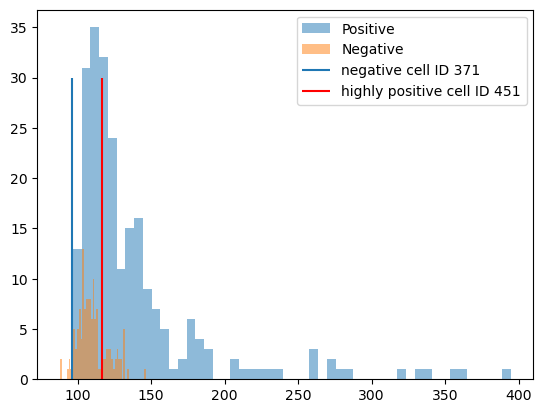

In [254]:
import matplotlib.pyplot as plt

# Separate the positive and negative values into separate dataframes
df_pos = result_df[result_df['label'] == 'positive']
df_neg = result_df[result_df['label'] == 'negative']
# Plot the histograms
plt.hist(df_pos['Mean Pixel Value BG RM'], bins=50, alpha=0.5, label='Positive')
plt.hist(df_neg['Mean Pixel Value BG RM'], bins=50, alpha=0.5, label='Negative')
plt.vlines(96.26482391, ymin = 0, ymax = 30, label = 'negative cell ID 371')
plt.vlines(116.66760254, ymin = 0, ymax = 30, label = 'highly positive cell ID 451', color = 'red')
plt.legend(loc='upper right')
plt.show()

# Seems like the BG removal did some good 

### inspecting individual cells

In [257]:
rfp_t0_bgrm = images[0,1,...]

In [258]:
viewer.add_image(rfp_t0_bgrm)

<Image layer 'rfp_t0_bgrm' at 0x7f7e058e5970>

In [259]:
rfp_451 = segment_451*rfp_t0_bgrm

In [261]:
viewer.add_image(rfp_451)

<Image layer 'rfp_451' at 0x7f7e061939d0>

In [262]:
rfp_371 = segment_371*rfp_t0_bgrm

In [264]:
viewer.add_image(rfp_371)

<Image layer 'rfp_371' at 0x7f7e06a188b0>

In [274]:
rfp_451_crop = rfp_451[1570:1900, 0:430]

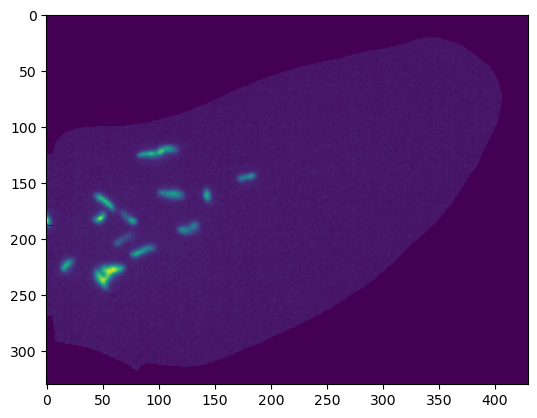

In [277]:
plt.imshow(rfp_451_crop)


KeyboardInterrupt



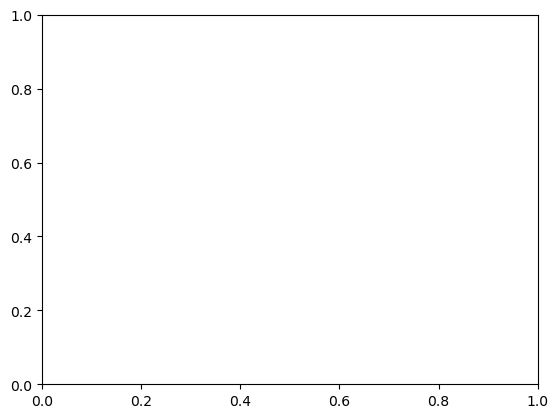

In [278]:
plt.hist(rfp_451_crop>0)

In [268]:
# Find the indices of the non-zero pixels
nonzero_indices = np.where(rfp_451 != 0)

# Determine the bounding box of the non-zero segment
min_x, min_y = np.min(nonzero_indices, axis=1)
max_x, max_y = np.max(nonzero_indices, axis=1)

# Crop the image to the bounding box
cropped_rfp_451 = Image.fromarray(arr[min_x:max_x+1, min_y:max_y+1])


KeyboardInterrupt



In [ ]:
test

In [ ]:
plt.hist(rfp_371)